In [32]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

# Antes se usaba otra función en la que venían los datos ordenados, pero la cambiarion y vienen sin orden
# Para solucionarlo definimos esta función

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

# mnist["data"] es un array de una fila por instancia y una columna por "feature"
# mnist["target"] es un array con los labels

X, y = mnist["data"], mnist["target"]

In [24]:
# Podemos comprobar la forma, 70.000 imágenes con 784 atributos, 28*28 pixeles que pueden ir de 0 (blanco)
# a 255 (negro)

X.shape

(70000, 784)

In [25]:
# y debe tener 70.000 labels, una por instancia o imagen

y.shape

(70000,)

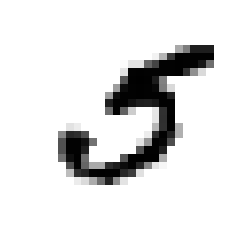

In [26]:
# Vamos a tomar una imagen cualquiera y mostrarla, por ejemplo la 36000. Tomamos su vector X, la escalamos a
# un array de 28*28, y hacemos el plot con imshow.

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [27]:
# Tiene pinta de ser un 5, y lo comprobamos viendo su label

y[36000]

5

In [28]:
# Antes de empezar a trabajar con el dataset debemos separar el training set del test set.
# MNIST ya viene preparado para ello, las primeras 60.000 imagenes para training y las 10.000 restantes test.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [29]:
# Deberíamos también mezclar los datos para que los folds de cross-validation sean similares y no falten dígitos

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [30]:
# Clasificador Binario

# Vamos a simplificar primero el problema, entrenando un sistema que detecte si un dígito es un 5 o no lo es.
# Primero creamos los vectores objetivo para esta tarea de clasificación

y_train_5 = (y_train == 5) # Verdadero para los 5s, falso para todos los demás
y_test_5 = (y_test == 5)

In [31]:
# SGD Classifier
# Un buen lugar para empezar es un 'Stochastic Gradient Descent Classifier', usando las herramientas de 
# Scikit-Learn. Este clasificador es capaz de manejar muchos datos de forma eficaz. Lo entrenaremos con todo el
# training set, con 'random_state' fijo a 42 ya que si no sería aleatorio, así siempre nos sale lo mismo. Los
# parámetros max_iter y tol son relativamente nuevos, así que añadimos estos valores para que cuadren con el libro

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

# Predecimos la imagen que vimos antes

sgd_clf.predict([some_digit])

# Nos da true, con lo que la identifica como un 5. Parece que ha funcionado correctamente, así que evaluaremos 
# el rendimiento del modelo.

array([ True])

In [33]:
# Mediciones de Rendimiento

# Cross-Validation
# cross_val_score con 3 folds.

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

# Parece que sale un "accuracy" altísimo, pero esto se debe a que hay muchas imágenes que no son 5. Por ello
# la medida de "accuracy" no es la medida preferida para los clasificadores. Especialmente en los datasets
# 'skewed', es decir, cuando unas clases son mucho más frecuentes que otras

array([0.96025, 0.8396 , 0.85925])

In [ ]:
# NOTA
# En ocasiones necesitamos más control que el que nos proporciona cross_val_score. Para ello podemos usar esto:
#
# from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3, random_state=42)

# for train_index, test_index in skfolds.split(X_train, y_train_5):
#     clone_clf = clone(sgd_clf)
#     X_train_folds = X_train[train_index]
#     y_train_folds = (y_train_5[train_index])
#     X_test_fold = X_train[test_index]
#     y_test_fold = (y_train_5[test_index])

#     clone_clf.fit(X_train_folds, y_train_folds)
#     y_pred = clone_clf.predict(X_test_fold)
#     n_correct = sum(y_pred == y_test_fold)
#     print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

In [ ]:
# Matriz de Confusión

# Una forma mucho mejor de evaluar el comportamiento de un clasificador es mirar la matriz de confusión.
# La idea general es conar el número de veces que una instancia de clase A es clasificada como clase B.
# Por ejemplo, para saber el número de veces que el clasificador confundió imágenes de 5s con 3s, tienes que
# mirar en la quinta fila y tercera columna de la matriz de confusión.